# Exploratory Data Science

Data exploration and understanding the task at hand is a fundamental step in the Machine Learning workflow.
In this notebook, we'll take an opportunity to explore the use case, data and models we'll be using.

We have been tasked with developing an application which can identify objects in static and live images. In this notebook we use a pre-trained machine learning model, and explore how it works on static photos. This notebook closely follows the tutorial and code provided by the TensorFlow Hub team [here](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).


To begin, we import a range of python packages:

In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont

import matplotlib.pyplot as plt
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print('Imported libraries')

2024-05-23 07:16:07.807498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 07:16:07.807562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 07:16:07.808906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 07:16:07.816554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 07:16:08.818938: W tensorflow/comp

Imported libraries


## Connect to data in s3

Before we get started with exploring our model, we first need to load some data to test the model against. This data is stored in an s3 bucket, and we connect to it using the `boto3` library. The `boto3` library was built into the standard data science notebook image, which we selected from the spawner page. As such, it is already installed in our environment.

In [2]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config

print('Imported s3 libraries')

Imported s3 libraries


In [3]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3.download_file('dog-detector', 'twodogs.jpg', 'twodogs.jpg')

print('Downloaded twodogs.jpg')

Downloaded twodogs.jpg


You should be able to see that this file has been added to your file directory on the left hand side of the screen.

## Import our image

In the next cell we import the image we want to test our model on.

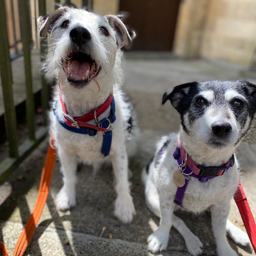

In [4]:
dog_img = 'twodogs.jpg'
dogs = Image.open(dog_img)
dogs.resize((256, 256))

This image shows two dogs, Max and Margot. We need to import the image using as a Tensor so the TensorFlow model we will use can process the image.

In [5]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

print('Defined load_img function')

Defined load_img function


In [6]:
tf_dogs = load_img(dog_img)
tf_dogs

<tf.Tensor: shape=(1192, 1192, 3), dtype=uint8, numpy=
array([[[ 47,  48,  30],
        [ 47,  48,  30],
        [ 47,  50,  31],
        ...,
        [224, 211, 176],
        [224, 211, 176],
        [224, 211, 176]],

       [[ 48,  49,  31],
        [ 48,  49,  31],
        [ 47,  50,  31],
        ...,
        [222, 209, 174],
        [222, 209, 174],
        [222, 209, 174]],

       [[ 49,  50,  32],
        [ 49,  50,  32],
        [ 48,  51,  32],
        ...,
        [224, 209, 176],
        [224, 209, 176],
        [224, 209, 176]],

       ...,

       [[ 42,  33,  24],
        [ 37,  27,  17],
        [ 35,  21,  10],
        ...,
        [236, 220, 197],
        [222, 204, 182],
        [220, 202, 180]],

       [[ 37,  28,  19],
        [ 33,  23,  13],
        [ 37,  20,  10],
        ...,
        [228, 213, 190],
        [232, 217, 194],
        [232, 217, 194]],

       [[ 39,  30,  21],
        [ 36,  26,  16],
        [ 41,  24,  14],
        ...,
        [233, 221, 

## Load in a model

The model we are going to use today is the ssd Mobilenet v2/1 model, which you can download from TensorFlow Hub [here](https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1). The model has been trained on Google's [Open Images](https://storage.googleapis.com/openimages/web/index.html) v4 data set, and can recognise 600 types of objects. We begin by loading in the model.

In [7]:
model_dir = 'models/openimages_v4_ssd_mobilenet_v2_1'
saved_model = tf.saved_model.load(model_dir)
detector = saved_model.signatures['default']

print('Loaded model into the detector variable')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Loaded model into the detector variable


In [9]:
converted_img = tf.image.convert_image_dtype(tf_dogs, tf.float32)[tf.newaxis, ...]
converted_img

<tf.Tensor: shape=(1, 1192, 1192, 3), dtype=float32, numpy=
array([[[[0.18431373, 0.18823531, 0.11764707],
         [0.18431373, 0.18823531, 0.11764707],
         [0.18431373, 0.19607845, 0.12156864],
         ...,
         [0.87843144, 0.82745105, 0.6901961 ],
         [0.87843144, 0.82745105, 0.6901961 ],
         [0.87843144, 0.82745105, 0.6901961 ]],

        [[0.18823531, 0.19215688, 0.12156864],
         [0.18823531, 0.19215688, 0.12156864],
         [0.18431373, 0.19607845, 0.12156864],
         ...,
         [0.8705883 , 0.8196079 , 0.68235296],
         [0.8705883 , 0.8196079 , 0.68235296],
         [0.8705883 , 0.8196079 , 0.68235296]],

        [[0.19215688, 0.19607845, 0.1254902 ],
         [0.19215688, 0.19607845, 0.1254902 ],
         [0.18823531, 0.20000002, 0.1254902 ],
         ...,
         [0.87843144, 0.8196079 , 0.6901961 ],
         [0.87843144, 0.8196079 , 0.6901961 ],
         [0.87843144, 0.8196079 , 0.6901961 ]],

        ...,

        [[0.16470589, 0.12941177

In [15]:
result = detector(converted_img)
result

{'detection_scores': <tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([0.8483348 , 0.7970174 , 0.21159178, 0.15999532, 0.14871337,
        0.1416307 , 0.13920765, 0.1387096 , 0.13142541, 0.1313616 ,
        0.12723546, 0.12589139, 0.12526104, 0.11713728, 0.11584367,
        0.11551823, 0.1146793 , 0.11404966, 0.11225974, 0.1108838 ,
        0.11020643, 0.10960091, 0.10959269, 0.10560258, 0.10557192,
        0.10429426, 0.10332609, 0.1027577 , 0.1020704 , 0.10065328,
        0.10062047, 0.09993551, 0.09861763, 0.09759153, 0.09758805,
        0.0975861 , 0.09671634, 0.09597343, 0.09553177, 0.09437597,
        0.09372265, 0.09337876, 0.08838151, 0.08822673, 0.08757588,
        0.08745306, 0.08704077, 0.08633854, 0.08501185, 0.08460203,
        0.0831232 , 0.0829018 , 0.08268093, 0.08238275, 0.08170386,
        0.08148941, 0.08146017, 0.08125888, 0.08051047, 0.08050565,
        0.07964257, 0.07915902, 0.07884585, 0.07830361, 0.07814885,
        0.07778199, 0.0770278 , 0.07682711, 0.0

The model has returned a dictionary, containing arrays, each of which holds information about the detected objects. The information includes identifiers for the types of objects, coordinates locating the objects within the image, and detection scores, corresponding to how certain the model is about its prediction.

We can use afew functions to help us to superimpose the information in this dictionary onto the origional image.

In [20]:
def display_image(image):
    fig = plt.figure(figsize=(10, 10))
    plt.grid(False)
    plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                 ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # Calculate total height of the display strings added to the top of the bounding box
    display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                 display_str,
                 fill="black",
                 font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image


print('Defined image display functions')

Defined image display functions


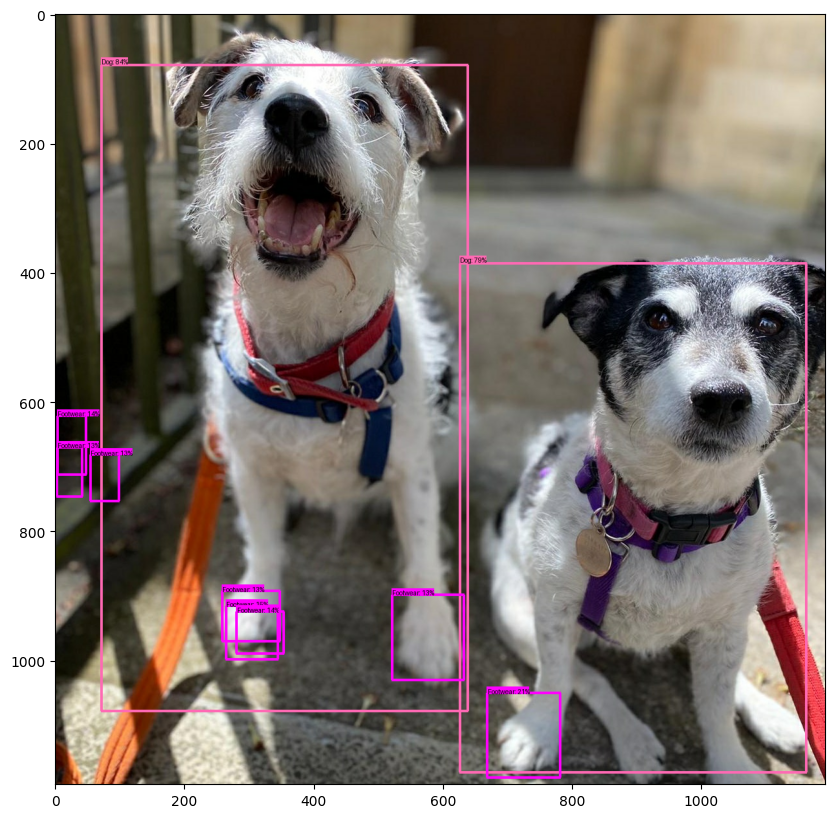

In [23]:
result = {key: np.asarray(value) for key, value in result.items()}

image_with_boxes = draw_boxes(
    tf_dogs.numpy(), result["detection_boxes"],
    result["detection_class_entities"], result["detection_scores"])

display_image(image_with_boxes)

So, you can see we've got some predictions for 'dog' and also some for 'footwear', and we can now see what parts of the image have been identified as such.

However, if we look at the detection scores, some of the predictions are not made with high confidence:

In [24]:
result['detection_scores']

array([0.8483348 , 0.7970174 , 0.21159178, 0.15999532, 0.14871337,
       0.1416307 , 0.13920765, 0.1387096 , 0.13142541, 0.1313616 ,
       0.12723546, 0.12589139, 0.12526104, 0.11713728, 0.11584367,
       0.11551823, 0.1146793 , 0.11404966, 0.11225974, 0.1108838 ,
       0.11020643, 0.10960091, 0.10959269, 0.10560258, 0.10557192,
       0.10429426, 0.10332609, 0.1027577 , 0.1020704 , 0.10065328,
       0.10062047, 0.09993551, 0.09861763, 0.09759153, 0.09758805,
       0.0975861 , 0.09671634, 0.09597343, 0.09553177, 0.09437597,
       0.09372265, 0.09337876, 0.08838151, 0.08822673, 0.08757588,
       0.08745306, 0.08704077, 0.08633854, 0.08501185, 0.08460203,
       0.0831232 , 0.0829018 , 0.08268093, 0.08238275, 0.08170386,
       0.08148941, 0.08146017, 0.08125888, 0.08051047, 0.08050565,
       0.07964257, 0.07915902, 0.07884585, 0.07830361, 0.07814885,
       0.07778199, 0.0770278 , 0.07682711, 0.07639266, 0.07605624,
       0.07517997, 0.07277044, 0.07122827, 0.07095907, 0.07028

Let's only draw boxes if the model was over 30% confident that the object was correctly classified.

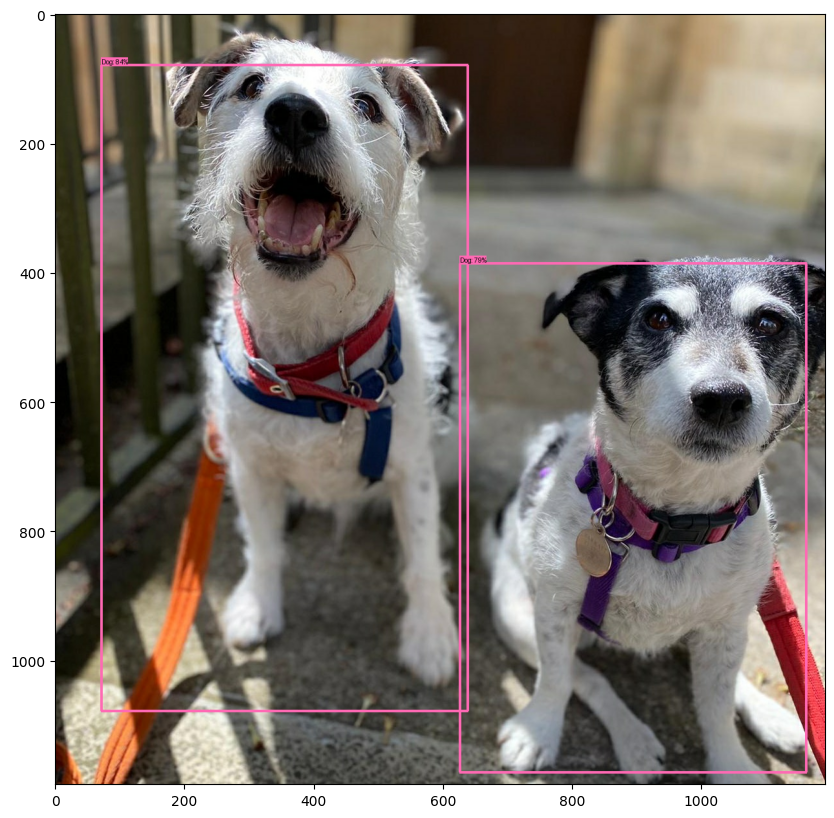

In [25]:
per = 0.3
image_with_boxes_per = draw_boxes(
    tf_dogs.numpy(), result["detection_boxes"][result["detection_scores"] > per],
    result["detection_class_entities"][result["detection_scores"] > per],
    result["detection_scores"][result["detection_scores"] > per])

display_image(image_with_boxes_per)



Fantastic! So you've seen how we can use a pre-trained model to identify objects in images. In the next notebooks, we will wrap this model in a flask app, which we can use as part of a larger application.